In [24]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Imports for decision tree visualization
import pydotplus
from IPython.display import Image

In [2]:
# Read in the Dataset
file_path = Path("Resources/reimbursement_data.csv")
reimburse_df = pd.read_csv(file_path)
reimburse_df.head()

Resolution  Manufacturer Rejection Reason  Days to resolve  \
0  Write Off  Duplicate Reimbursement Claim               12   
1  Write Off      Wrong Customer Identifier               19   
2  Write Off       Incorrect Contract Price               14   
3   Resubmit                  Claim Too Old                7   
4  Write Off                  Claim Too Old              134   

   Adjustment Amount    DC        DC City DM Create Date     DM ID #  \
0            -184.10  8182   W.Sacramento      10/1/2020  1275GTVASM   
1            -131.88  8148         Duluth      10/1/2020  1275GAKNAL   
2             -52.40  8149        Memphis      10/1/2020  1275GAKNMD   
3             -38.64  8126        McCalla      10/1/2020  1275GVRTBI   
4             -36.00  8165  Oklahoma City      10/1/2020  1275GPIIOC   

  Manufacturer Name  Manufacturer ID  ...  Product Name Customer ID  \
0        Supplier 9                9  ...     Drug # 11      730048   
1        Supplier 1                1  ...      Drug # 2      155260   
2        Supplier 1                1  ...      Drug # 1      528125   
3       Supplier 17               17  ...     Drug # 49      504084   
4        Supplier 7                7  ...      Drug # 9      467382   

     Customer Group Customer Group ID  days from order to invoice  Units Sold  \
0  Customer Group 9                 9                          61          -1   
1  Customer Group 2                 2                          51          -1   
2  Customer Group 1                 1                          98          -1   
3  Customer Group 4                 4                         388          -1   
4  Customer Group 1                 1                         416          -4   

   Reimbursement Amount  Contract Lead  Contract ID  Chrgbk Doc #  
0               -184.10          40019            7    2896083484  
1               -131.88         785477          163    2895901196  
2                -68.51         474335           78    2895873878  
3                -38.64         586439           96    2896465786  
4                -36.00         474335           78    2896018433  

[5 rows x 21 columns]

In [3]:
# Clean Data, drop unnecessary feature columns and those that are too detailed and would lead to overfitting (such as customer # and individual product IDs)
reimburse_df = reimburse_df[["Resolution","Manufacturer Rejection Reason","Days to resolve","DC","Manufacturer ID","Customer Group ID", "days from order to invoice","Contract ID"]]
reimburse_df.head()

Resolution  Manufacturer Rejection Reason  Days to resolve    DC  \
0  Write Off  Duplicate Reimbursement Claim               12  8182   
1  Write Off      Wrong Customer Identifier               19  8148   
2  Write Off       Incorrect Contract Price               14  8149   
3   Resubmit                  Claim Too Old                7  8126   
4  Write Off                  Claim Too Old              134  8165   

   Manufacturer ID  Customer Group ID  days from order to invoice  Contract ID  
0                9                  9                          61            7  
1                1                  2                          51          163  
2                1                  1                          98           78  
3               17                  4                         388           96  
4                7                  1                         416           78

In [4]:
# perform binary encoding on resolution and rejection code columns

reimburse_binary_df = pd.get_dummies(reimburse_df, columns=["Resolution", "Manufacturer Rejection Reason"])
reimburse_binary_df.head()

Days to resolve    DC  Manufacturer ID  Customer Group ID  \
0               12  8182                9                  9   
1               19  8148                1                  2   
2               14  8149                1                  1   
3                7  8126               17                  4   
4              134  8165                7                  1   

   days from order to invoice  Contract ID  Resolution_Resubmit  \
0                          61            7                    0   
1                          51          163                    0   
2                          98           78                    0   
3                         388           96                    1   
4                         416           78                    0   

   Resolution_Write Off  Manufacturer Rejection Reason_Claim Too Old  \
0                     1                                            0   
1                     1                                            0   
2                     1                                            0   
3                     0                                            1   
4                     1                                            1   

   Manufacturer Rejection Reason_Customer Not Eligible  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Manufacturer Rejection Reason_Duplicate Reimbursement Claim  \
0                                                  1             
1                                                  0             
2                                                  0             
3                                                  0             
4                                                  0             

   Manufacturer Rejection Reason_Incorrect Contract ID  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Manufacturer Rejection Reason_Incorrect Contract Price  \
0                                                  0        
1                                                  0        
2                                                  1        
3                                                  0        
4                                                  0        

   Manufacturer Rejection Reason_No Reason Given  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Manufacturer Rejection Reason_Wrong Customer Identifier  
0                                                  0        
1                                                  1        
2                                                  0        
3                                                  0        
4                                                  0

In [5]:
# drop extra column in resolution binary
reimburse_binary_df = reimburse_binary_df.drop("Resolution_Resubmit", axis=1)

In [6]:
reimburse_binary_df.head()

Days to resolve    DC  Manufacturer ID  Customer Group ID  \
0               12  8182                9                  9   
1               19  8148                1                  2   
2               14  8149                1                  1   
3                7  8126               17                  4   
4              134  8165                7                  1   

   days from order to invoice  Contract ID  Resolution_Write Off  \
0                          61            7                     1   
1                          51          163                     1   
2                          98           78                     1   
3                         388           96                     0   
4                         416           78                     1   

   Manufacturer Rejection Reason_Claim Too Old  \
0                                            0   
1                                            0   
2                                            0   
3                                            1   
4                                            1   

   Manufacturer Rejection Reason_Customer Not Eligible  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Manufacturer Rejection Reason_Duplicate Reimbursement Claim  \
0                                                  1             
1                                                  0             
2                                                  0             
3                                                  0             
4                                                  0             

   Manufacturer Rejection Reason_Incorrect Contract ID  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Manufacturer Rejection Reason_Incorrect Contract Price  \
0                                                  0        
1                                                  0        
2                                                  1        
3                                                  0        
4                                                  0        

   Manufacturer Rejection Reason_No Reason Given  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Manufacturer Rejection Reason_Wrong Customer Identifier  
0                                                  0        
1                                                  1        
2                                                  0        
3                                                  0        
4                                                  0

In [7]:
# Specify features 
X = reimburse_binary_df.copy()
X.drop("Resolution_Write Off", axis=1, inplace=True)
X.head()

Days to resolve    DC  Manufacturer ID  Customer Group ID  \
0               12  8182                9                  9   
1               19  8148                1                  2   
2               14  8149                1                  1   
3                7  8126               17                  4   
4              134  8165                7                  1   

   days from order to invoice  Contract ID  \
0                          61            7   
1                          51          163   
2                          98           78   
3                         388           96   
4                         416           78   

   Manufacturer Rejection Reason_Claim Too Old  \
0                                            0   
1                                            0   
2                                            0   
3                                            1   
4                                            1   

   Manufacturer Rejection Reason_Customer Not Eligible  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Manufacturer Rejection Reason_Duplicate Reimbursement Claim  \
0                                                  1             
1                                                  0             
2                                                  0             
3                                                  0             
4                                                  0             

   Manufacturer Rejection Reason_Incorrect Contract ID  \
0                                                  0     
1                                                  0     
2                                                  0     
3                                                  0     
4                                                  0     

   Manufacturer Rejection Reason_Incorrect Contract Price  \
0                                                  0        
1                                                  0        
2                                                  1        
3                                                  0        
4                                                  0        

   Manufacturer Rejection Reason_No Reason Given  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Manufacturer Rejection Reason_Wrong Customer Identifier  
0                                                  0        
1                                                  1        
2                                                  0        
3                                                  0        
4                                                  0

In [8]:
# Define dependent variable/target vector
y = reimburse_binary_df[["Resolution_Write Off"]]

In [9]:
# check data type
type(X), type(y)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [10]:
# check shape
X.shape, y.shape

((56399, 13), (56399, 1))

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [12]:
# Create StandardScaler instance
scaler = StandardScaler()

In [13]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [14]:
# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [15]:
# Creating the decision tree classifier instance
model = tree.DecisionTreeClassifier()

In [16]:
# Fitting the model
model = model.fit(X_train_scaled, y_train)

In [17]:
# Making predictions using the testing data
predictions = model.predict(X_test_scaled)

In [18]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)



In [19]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


Predicted 0  Predicted 1
Actual 0         8950          128
Actual 1          117         4905

Accuracy Score : 0.9826241134751773
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9078
           1       0.97      0.98      0.98      5022

    accuracy                           0.98     14100
   macro avg       0.98      0.98      0.98     14100
weighted avg       0.98      0.98      0.98     14100



In [20]:
# Create DOT data
dot_data = tree.export_graphviz(
    model, out_file=None, feature_names=X.columns, class_names=["0", "1"], filled=True
)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)

# Show graph
Image(graph.create_png())



dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.588731 to fit



In [22]:
# Saving the tree as PDF
file_path = ("Resources/reimburse_tree.pdf")
graph.write_pdf(file_path)

# Saving the tree as PNG
file_path = ("Resources/reimburse_tree.png")
graph.write_png(file_path)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.588731 to fit



True

In [25]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [26]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

C:\Users\alexg\anaconda3\envs\dev\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [27]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)


In [28]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [29]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))


Confusion Matrix


Predicted 0  Predicted 1
Actual 0         8971          107
Actual 1          125         4897

Accuracy Score : 0.9835460992907802
Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      9078
           1       0.98      0.98      0.98      5022

    accuracy                           0.98     14100
   macro avg       0.98      0.98      0.98     14100
weighted avg       0.98      0.98      0.98     14100



In [30]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_

In [31]:
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.45322809166343275, 'Manufacturer ID'),
 (0.22185472380810456, 'Days to resolve'),
 (0.07715492045828559, 'Contract ID'),
 (0.06892046066184483, 'Customer Group ID'),
 (0.03745171842052013, 'DC'),
 (0.036202467869111715, 'days from order to invoice'),
 (0.0338301572507894, 'Manufacturer Rejection Reason_No Reason Given'),
 (0.030387110166838614,
  'Manufacturer Rejection Reason_Incorrect Contract Price'),
 (0.022459473669895907, 'Manufacturer Rejection Reason_Customer Not Eligible'),
 (0.01027364559352949,
  'Manufacturer Rejection Reason_Wrong Customer Identifier'),
 (0.004979057827959121,
  'Manufacturer Rejection Reason_Duplicate Reimbursement Claim'),
 (0.0031452044859977537, 'Manufacturer Rejection Reason_Claim Too Old'),
 (0.0001129681236901395,
  'Manufacturer Rejection Reason_Incorrect Contract ID')]


Bad key savefig.frameon in file C:\Users\alexg\anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file C:\Users\alexg\anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file C:\Users\alexg\anaconda3\envs\dev\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 473 ('verbose.fileo  : sys.stdout  # a log filename, sys.stdout or sys.stderr')
You probably need to get 

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

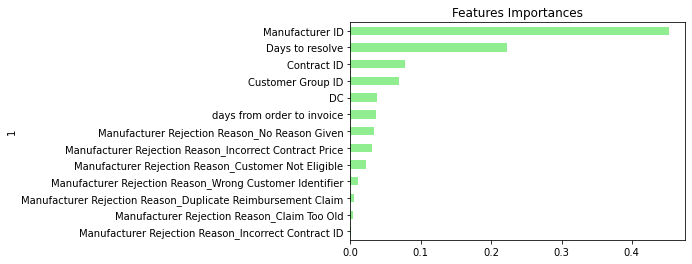

In [32]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)
